In [147]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
import folium
import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

from make_fishnet import make_fishnet
import GOSTnet as gn

from shapely.geometry import mapping, Polygon, box
import fiona

Populating the interactive namespace from numpy and matplotlib


In [186]:
pth = '/Users/nicholasjones/Desktop/code/MENA/data/saudi_maps/'

In [208]:
def make_gdf(file_name):
    shp = pd.read_csv(os.path.join(pth, file_name))
    shp = shp[['Name_E','E','N','Area_m2']]
    shp['geometry'] = (list(zip(shp.E,shp.N)))
    shp['geometry'] = shp.geometry.apply(lambda x: Point(x))
    shp = gpd.GeoDataFrame(shp, crs = {'init' :'epsg:4326'})
    return(shp)

In [209]:
parks_madinah = make_gdf('madinah_parks.csv')
parks_dammam = make_gdf('dammam_parks.csv')
parks_jeddah = make_gdf('jeddah_parks.csv')
parks_makkah = make_gdf('makkah_parks.csv')
parks_riyadh = make_gdf('riyadh_parks.csv')

In [247]:
def get_bounds(parks_gdf, buffer_fraction):
    '''parks_gdf: geodataframe of parks
       buffer_fraction: fraction of bounding box dimensions by which to buffer (between 0 to 1)'''
    bounds = parks_gdf.unary_union.bounds
    x_width = abs(bounds[2] - bounds[0])
    y_height = abs(bounds[3] - bounds[1])
    minx = bounds[0] - (x_width * buffer_fraction)
    miny = bounds[1] + (y_height * buffer_fraction)
    maxx = bounds[2] - (x_width * buffer_fraction)
    maxy = bounds[3] + (y_height * buffer_fraction)
    return(minx, miny, maxx, maxy)

In [269]:
def create_network(pois_gdf, bounding_increment):
    coords = get_bounds(pois_gdf, bounding_increment)
    coords = (coords[1],coords[0],coords[3],coords[2])
    return(osm.pdna_network_from_bbox(*coords))

In [303]:
%%time
print(1)

1
CPU times: user 249 µs, sys: 136 µs, total: 385 µs
Wall time: 271 µs


In [304]:
%%time

G_dammam = create_network(parks_dammam, 0.2)
G_madinah = create_network(parks_madinah, 0.2)
G_jeddah = create_network(parks_jeddah, 0.2)
G_makkah = create_network(parks_makkah, 0.2)
G_riyadh = create_network(parks_riyadh, 0.2)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](26.37420000,49.95993600,26.51535000,50.16285600);>;);out;'}"
Downloaded 4,359.5KB from www.overpass-api.de in 2.35 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 2.51 seconds
Returning OSM data with 31,426 nodes and 8,771 ways...
Edge node pairs completed. Took 16.82 seconds
Returning processed graph with 17,177 nodes and 26,433 edges...
Completed OSM data download and Pandana node and edge table creation in 21.32 seconds
Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|pro

In [273]:
fig_kwargs={'figsize': [10,10]}
bmap_kwargs={'suppress_ticks': False,'epsg': '4326'}
plot_kwargs={'cmap': 'viridis', 's': 8, 'edgecolor': 'none'}
hex_plot_kwargs = {'gridsize':40,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

In [ ]:
network.

#### 3. Plot accessibility from any node to nearest amenity

In [308]:
def plot_accessibility(network, pois_gdf, distance, n, city_name):
    network.precompute(distance) 
    network.set_pois(category='all', maxdist = distance,x_col=pois_gdf['E'], maxitems=1, y_col=pois_gdf['N'])
    access_table = network.nearest_pois(distance=distance, category='all', num_pois=1)
    bmap, fig, ax = network.plot(access_table[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
    ax.set_facecolor('k')
    ax.set_title('{}: Driving distance to nearest park, meters)'.format(city_name), fontsize=14);

In [355]:
def plot_accessibility_and_roads(network, pois_gdf, distance, n, city_name,
                                 highway = ['motorway','trunk','primary','secondary'],
                                 bounding_increment = 0.2):
    network.precompute(distance) 
    network.set_pois(category='all', maxdist = distance,x_col=pois_gdf['E'], maxitems=1, y_col=pois_gdf['N'])
    access_table = network.nearest_pois(distance=distance, category='all', num_pois=1)
    bmap, fig, ax = network.plot(access_table[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
    ax.set_facecolor('k')
    ax.set_title('{}: Driving distance to nearest park, meters)'.format(city_name), fontsize=14);

    coords = get_bounds(pois_gdf, bounding_increment)
    G_roads = ox.graph_from_bbox(coords[3],coords[1],coords[2],coords[0])
    gdf_roads = ox.graph_to_gdfs(G_roads, nodes=False, edges = True)
    gdf_roads['highway'] = gdf_roads.highway.astype(str)
    gdf_roads[gdf_roads.highway.isin(['motorway','trunk','primary'])].plot(ax = ax, color = 'w', alpha = 0.5)

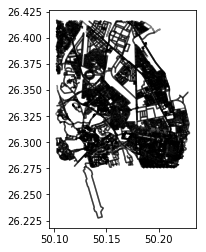

In [350]:
coords = get_bounds(parks_dammam, -0.5)
G_roads = ox.graph_from_bbox(coords[3],coords[1],coords[2],coords[0])
gdf_roads = ox.graph_to_gdfs(G_roads, nodes=False, edges = True)
gdf_roads['highway'] = gdf_roads.highway.astype(str)
gdf_roads.plot(color = 'k', alpha = 0.5)

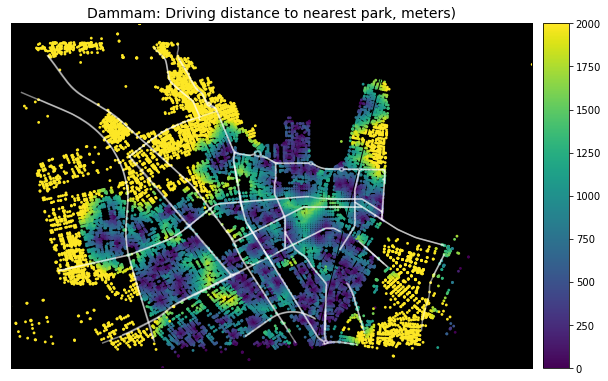

In [356]:
plot_accessibility_and_roads(G_dammam, parks_dammam, 2000, 1, 'Dammam')

In [314]:
parks_jeddah.dropna(inplace=True)

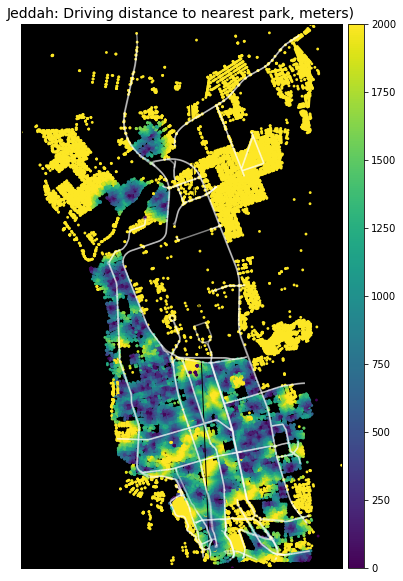

In [357]:
plot_accessibility_and_roads(G_jeddah, parks_jeddah, 2000, 1, 'Jeddah')

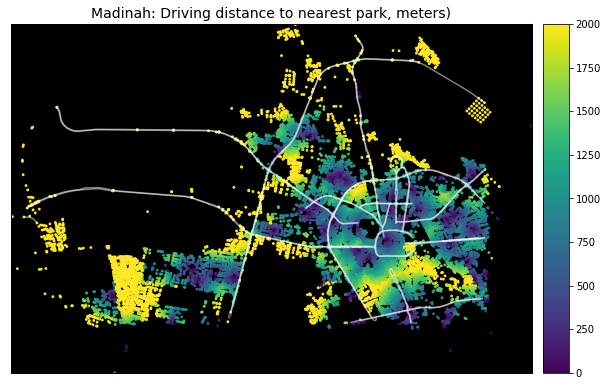

In [358]:
plot_accessibility_and_roads(G_madinah, parks_madinah, 2000, 1, 'Madinah')

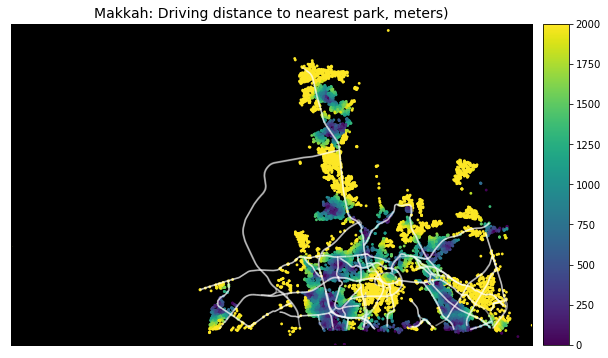

In [362]:
plot_accessibility_and_roads(G_makkah, parks_makkah, 2000, 1, 'Makkah')

In [319]:
parks_riyadh.dropna(inplace=True)

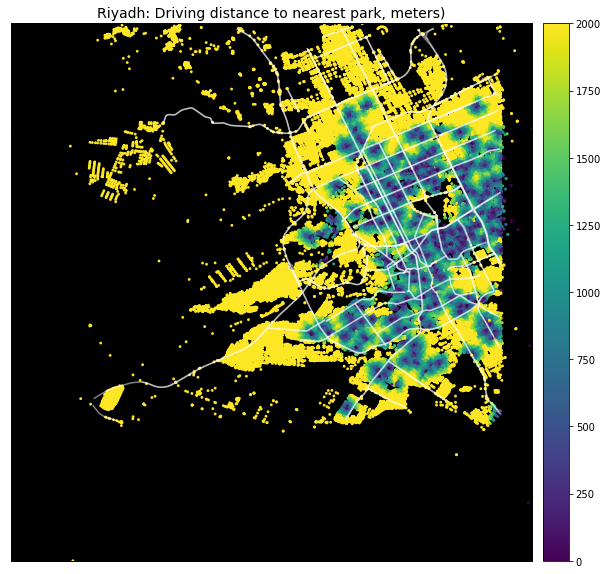

In [360]:
plot_accessibility_and_roads(G_riyadh, parks_riyadh, 2000, 1, 'Riyadh')

In [ ]:
plot_accessibility(G, parks_dammam, 2000, 1, 'Dammam')

Variables to define:
 - distance: compute accessibility within this distance from any point
 - num_pois: calculate distance to this many amenities [ie. to first, second, third ... n amenities]

In [281]:
G_dammam.set_pois(category='all', maxdist = distance,x_col=parks_dammam['E'], maxitems=1, y_col=parks_dammam['N'])
#network.set_pois(category='hospital', maxdist = distance,maxitems = num_pois,
#                 x_col=pois[pois.amenity.isin(['hospital'])]['lon'], 
#                             y_col=pois[pois.amenity.isin(['hospital'])]['lat'])

all_access = G_dammam.nearest_pois(distance=distance, category='all', num_pois=1)
#hosp_access = network.nearest_pois(distance=distance, category='hospital', num_pois=num_pois)
print('{:,} nodes'.format(len(all_access)))

17,177 nodes


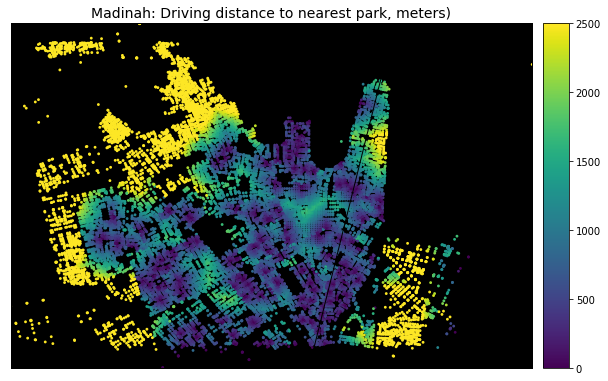

In [278]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = G_dammam.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
#shp.plot(color='r',ax = ax)
ax.set_title('Madinah: Driving distance to nearest park, meters)', fontsize=14);

In [148]:
make_fishnet('grid.shp',*coords,500,500) # takes xmin, xmax, ymin, ymax

In [151]:
grid=gpd.read_file('grid.shp')
#ax = grid.plot(facecolor='w',edgecolor='b',lw=0.1)
#nodes_gdf.plot(ax=ax)
#shp.plot(ax=ax,color='r')
#ax.set_title('Street network and POIs: nodes in blue, POIs in red');

In [153]:
coords

(24.25, 39.4, 24.65, 39.8)

In [152]:
grid.shape

(10341618, 2)

In [ ]:
grid['centroid'] = grid.geometry.centroid

In [ ]:
grid['nearest_node'] = np.nan
grid['nearest_node'] = network.get_node_ids(grid.centroid.x,grid.centroid.y,mapping_distance=10)
grid.isnull().sum()

In [ ]:

distances = []
for i in range(grid.shape[0]):
    node = grid.nearest_node[i]
    distance = all_access.loc[node,1]
    distances.append(distance)  

In [179]:
G = ox.graph_from_address("Madinah, Saudi Arabia", distance=20000)

In [180]:
gdf = ox.graph_to_gdfs(G, nodes=False, edges = True)

In [181]:
gdf['highway'] = gdf.highway.astype(str)

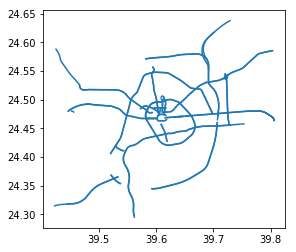

In [182]:
gdf[gdf.highway.isin(['motorway','trunk','primary'])].plot()

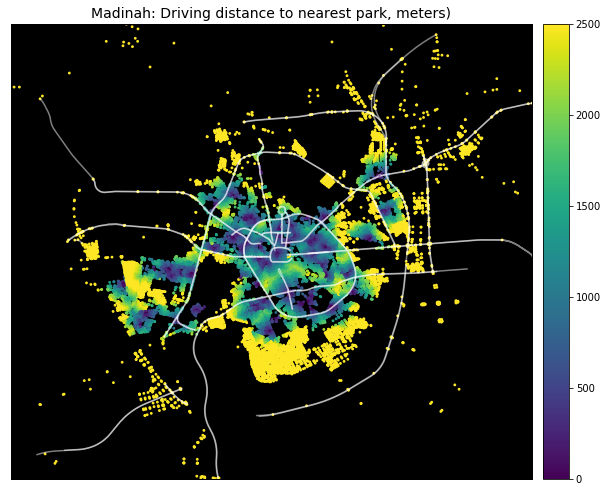

In [183]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
gdf[gdf.highway.isin(['motorway','trunk','primary'])].plot(ax = ax, color = 'w', alpha = 0.5)
#shp.plot(color='r',ax = ax)
ax.set_title('Madinah: Driving distance to nearest park, meters)', fontsize=14);

In [170]:
gdf.highway.value_counts()

residential                                 40646
tertiary                                     4265
secondary                                    1336
service                                      1325
primary                                       791
pedestrian                                    570
unclassified                                  553
trunk                                         228
motorway                                      170
secondary_link                                130
motorway_link                                 130
footway                                       117
primary_link                                  113
tertiary_link                                 106
trunk_link                                    102
living_street                                  29
['pedestrian', 'footway']                      16
['residential', 'service']                      6
['pedestrian', 'footway', 'steps']              6
['residential', 'unclassified']                 6
